<a href="https://colab.research.google.com/github/chandra-440/CBE20255/blob/master/cantera_exCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Cantera:

https://cantera.org/examples/python/index.html

In [ ]:
!pip install cantera      #bash to download a package.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 18.3 MB/s eta 0:00:00


In [ ]:
"""
This example solves a plug flow reactor problem, where the chemistry is
surface chemistry. The specific problem simulated is the partial oxidation of
methane over a platinum catalyst in a packed bed reactor.

Requires: cantera >= 2.5.0
Keywords: catalysis, reactor network, surface chemistry, plug flow reactor,
          packed bed reactor
"""

import csv

import cantera as ct

# unit conversion factors to SI
cm = 0.01
minute = 60.0

#######################################################################
# Input Parameters
#######################################################################

tc = 800.0  # Temperature in Celsius
length = 0.3 * cm  # Catalyst bed length
area = 1.0 * cm**2  # Catalyst bed area
cat_area_per_vol = 1000.0 / cm  # Catalyst particle surface area per unit volume
velocity = 40.0 * cm / minute  # gas velocity
porosity = 0.3  # Catalyst bed porosity

# input file containing the surface reaction mechanism
yaml_file = 'methane_pox_on_pt.yaml'

output_filename = 'surf_pfr_output.csv'

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 201
dt = 1.0

#####################################################################

t = tc + 273.15  # convert to Kelvin

# import the gas model and set the initial conditions
gas = ct.Solution(yaml_file, 'gas')
gas.TPX = t, ct.one_atm, 'CH4:1, O2:1.5, AR:0.1'

# import the surface model
surf = ct.Interface(yaml_file, 'Pt_surf', [gas])
surf.TP = t, ct.one_atm

rlen = length/(NReactors-1)
rvol = area * rlen * porosity

# catalyst area in one reactor
cat_area = cat_area_per_vol * rvol

mass_flow_rate = velocity * gas.density * area

# The plug flow reactor is represented by a linear chain of zero-dimensional
# reactors. The gas at the inlet to the first one has the specified inlet
# composition, and for all others the inlet composition is fixed at the
# composition of the reactor immediately upstream. Since in a PFR model there
# is no diffusion, the upstream reactors are not affected by any downstream
# reactors, and therefore the problem may be solved by simply marching from
# the first to last reactor, integrating each one to steady state.

TDY = gas.TDY
cov = surf.coverages

print('    distance       X_CH4        X_H2        X_CO')

# create a new reactor
gas.TDY = TDY
r = ct.IdealGasReactor(gas, energy='off')
r.volume = rvol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf = ct.ReactorSurface(surf, r, A=cat_area)

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r, downstream, master=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-9
sim.atol = 1.0e-21

output_data = []

for n in range(NReactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = r.thermo.TDY
    upstream.syncState()
    sim.reinitialize()
    sim.advance_to_steady_state()
    dist = n * rlen * 1.0e3  # distance in mm

    if n % 10 == 0:
        print('  {0:10f}  {1:10f}  {2:10f}  {3:10f}'.format(
            dist, *gas['CH4', 'H2', 'CO'].X))

    # write the gas mole fractions and surface coverages vs. distance
    output_data.append(
        [dist, r.T - 273.15, r.thermo.P/ct.one_atm] + list(gas.X)
        + list(surf.coverages)
    )

with open(output_filename, 'w', newline="") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Distance (mm)', 'T (C)', 'P (atm)'] +
                    gas.species_names + surf.species_names)
    writer.writerows(output_data)

print("Results saved to '{0}'".format(output_filename))

    distance       X_CH4        X_H2        X_CO
    0.000000    0.093914    0.000710    0.010245
    0.150000    0.060299    0.099170    0.021116
    0.300000    0.050054    0.128760    0.025897
    0.450000    0.044192    0.145294    0.029031
    0.600000    0.040134    0.156579    0.031357
    0.750000    0.037053    0.165073    0.033199
    0.900000    0.034581    0.171846    0.034720
    1.050000    0.032525    0.177454    0.036011
    1.200000    0.030769    0.182222    0.037132
    1.350000    0.029242    0.186359    0.038121
    1.500000    0.027892    0.190002    0.039004
    1.650000    0.026686    0.193251    0.039802
    1.800000    0.025598    0.196176    0.040527
    1.950000    0.024608    0.198833    0.041192
    2.100000    0.023701    0.201262    0.041805
    2.250000    0.022866    0.203496    0.042374
    2.400000    0.022092    0.205561    0.042903
    2.550000    0.021373    0.207480    0.043398
    2.700000    0.020702    0.209268    0.043862
    2.850000    0.02


This example illustrates a continuously stirred tank reactor (CSTR) with steady
inputs but periodic interior state.

A stoichiometric hydrogen/oxygen mixture is introduced and reacts to produce
water.  But since water has a large efficiency as a third body in the chain
termination reaction

       H + O2 + M = H2O + M

as soon as a significant amount of water is produced the reaction stops. After
enough time has passed that the water is exhausted from the reactor, the mixture
explodes again and the process repeats. This explanation can be verified by
decreasing the rate for reaction 7 in file h2o2.yaml and re-running the
example.

Acknowledgments: The idea for this example and an estimate of the conditions
needed to see the oscillations came from Bob Kee, Colorado School of Mines

Requires: cantera >= 2.5.0, matplotlib >= 2.0
Keywords: combustion, reactor network, well-stirred reactor, plotting



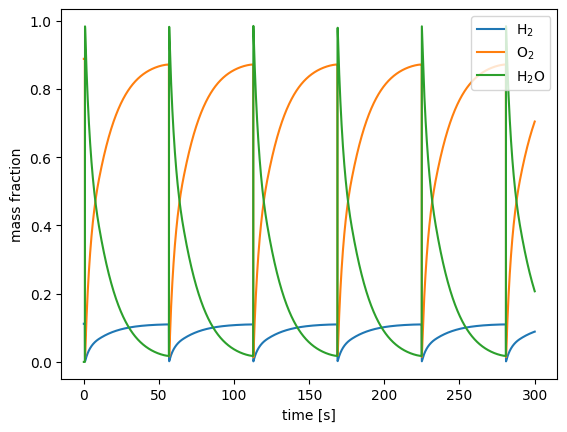

In [ ]:
"""
This example illustrates a continuously stirred tank reactor (CSTR) with steady
inputs but periodic interior state.

A stoichiometric hydrogen/oxygen mixture is introduced and reacts to produce
water.  But since water has a large efficiency as a third body in the chain
termination reaction

       H + O2 + M = H2O + M

as soon as a significant amount of water is produced the reaction stops. After
enough time has passed that the water is exhausted from the reactor, the mixture
explodes again and the process repeats. This explanation can be verified by
decreasing the rate for reaction 7 in file h2o2.yaml and re-running the
example.

Acknowledgments: The idea for this example and an estimate of the conditions
needed to see the oscillations came from Bob Kee, Colorado School of Mines

Requires: cantera >= 2.5.0, matplotlib >= 2.0
Keywords: combustion, reactor network, well-stirred reactor, plotting
"""

import cantera as ct
import matplotlib.pyplot as plt
# create the gas mixture
gas = ct.Solution('h2o2.yaml')

# pressure = 60 Torr, T = 770 K
p = 60.0*133.3
t = 770.0

gas.TPX = t, p, 'H2:2, O2:1'

# create an upstream reservoir that will supply the reactor. The temperature,
# pressure, and composition of the upstream reservoir are set to those of the
# 'gas' object at the time the reservoir is created.
upstream = ct.Reservoir(gas)

# Now create the reactor object with the same initial state
cstr = ct.IdealGasReactor(gas)

# Set its volume to 10 cm^3. In this problem, the reactor volume is fixed, so
# the initial volume is the volume at all later times.
cstr.volume = 10.0*1.0e-6

# We need to have heat loss to see the oscillations. Create a reservoir to
# represent the environment, and initialize its temperature to the reactor
# temperature.
env = ct.Reservoir(gas)

# Create a heat-conducting wall between the reactor and the environment. Set its
# area, and its overall heat transfer coefficient. Larger U causes the reactor
# to be closer to isothermal. If U is too small, the gas ignites, and the
# temperature spikes and stays high.
w = ct.Wall(cstr, env, A=1.0, U=0.02)

# Connect the upstream reservoir to the reactor with a mass flow controller
# (constant mdot). Set the mass flow rate to 1.25 sccm.
sccm = 1.25
vdot = sccm * 1.0e-6 / 60.0 * ((ct.one_atm / gas.P) * (gas.T / 273.15))  # m^3/s
mdot = gas.density * vdot  # kg/s
mfc = ct.MassFlowController(upstream, cstr, mdot=mdot)

# now create a downstream reservoir to exhaust into.
downstream = ct.Reservoir(gas)

# connect the reactor to the downstream reservoir with a valve, and set the
# coefficient sufficiently large to keep the reactor pressure close to the
# downstream pressure of 60 Torr.
v = ct.Valve(cstr, downstream, K=1.0e-9)

# create the network
network = ct.ReactorNet([cstr])

# now integrate in time
t = 0.0
dt = 0.1

states = ct.SolutionArray(gas, extra=['t'])
while t < 300.0:
    t += dt
    network.advance(t)
    states.append(cstr.thermo.state, t=t)

aliases = {'H2': 'H$_2$', 'O2': 'O$_2$', 'H2O': 'H$_2$O'}
for name, alias in aliases.items():
    gas.add_species_alias(name, alias)

if __name__ == '__main__':
    print(__doc__)
    plt.figure(1)
    for spc in aliases.values():
        plt.plot(states.t, states(spc).Y, label=spc)
    plt.legend(loc='upper right')
    plt.xlabel('time [s]')
    plt.ylabel('mass fraction')
    plt.show()

In [ ]:
"""
Mixing two streams.

Since reactors can have multiple inlets and outlets, they can be used to
implement mixers, splitters, etc. In this example, air and methane are mixed
in stoichiometric proportions. Due to the low temperature, no reactions occur.
Note that the air stream and the methane stream use *different* reaction
mechanisms, with different numbers of species and reactions. When gas flows
from one reactor or reservoir to another one with a different reaction
mechanism, species are matched by name. If the upstream reactor contains a
species that is not present in the downstream reaction mechanism, it will be
ignored. In general, reaction mechanisms for downstream reactors should
contain all species that might be present in any upstream reactor.

Compare this approach for the transient problem to the method used for the
steady-state problem in thermo/mixing.py.

Requires: cantera >= 2.5.0
Keywords: thermodynamics, reactor network, mixture
"""

import cantera as ct

# Use air for stream a.
gas_a = ct.Solution('air.yaml')
gas_a.TPX = 300.0, ct.one_atm, 'O2:0.21, N2:0.78, AR:0.01'
rho_a = gas_a.density


# Use GRI-Mech 3.0 for stream b (methane) and for the mixer. If it is desired
# to have a pure mixer, with no chemistry, use instead a reaction mechanism
# for gas_b that has no reactions.
gas_b = ct.Solution('gri30.yaml')
gas_b.TPX = 300.0, ct.one_atm, 'CH4:1'
rho_b = gas_b.density

# Create reservoirs for the two inlet streams and for the outlet stream.  The
# upsteam reservoirs could be replaced by reactors, which might themselves be
# connected to reactors further upstream. The outlet reservoir could be
# replaced with a reactor with no outlet, if it is desired to integrate the
# composition leaving the mixer in time, or by an arbitrary network of
# downstream reactors.
res_a = ct.Reservoir(gas_a)
res_b = ct.Reservoir(gas_b)
downstream = ct.Reservoir(gas_b)

# Create a reactor for the mixer. A reactor is required instead of a
# reservoir, since the state will change with time if the inlet mass flow
# rates change or if there is chemistry occurring.
gas_b.TPX = 300.0, ct.one_atm, 'O2:0.21, N2:0.78, AR:0.01'
mixer = ct.IdealGasReactor(gas_b)

# create two mass flow controllers connecting the upstream reservoirs to the
# mixer, and set their mass flow rates to values corresponding to
# stoichiometric combustion.
mfc1 = ct.MassFlowController(res_a, mixer, mdot=rho_a*2.5/0.21)
mfc2 = ct.MassFlowController(res_b, mixer, mdot=rho_b*1.0)

# connect the mixer to the downstream reservoir with a valve.
outlet = ct.Valve(mixer, downstream, K=10.0)

sim = ct.ReactorNet([mixer])

# Since the mixer is a reactor, we need to integrate in time to reach steady
# state
sim.advance_to_steady_state()

# view the state of the gas in the mixer
print(mixer.thermo.report())


  gri30:

       temperature   300 K
          pressure   1.0133e+05 Pa
           density   1.1361 kg/m^3
  mean mol. weight   27.968 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        -2.047e+05        -5.725e+06  J
   internal energy       -2.9388e+05       -8.2194e+06  J
           entropy            7158.8        2.0022e+05  J/K
    Gibbs function       -2.3523e+06       -6.5791e+07  J
 heat capacity c_p            1057.5             29578  J/K
 heat capacity c_v            760.26             21263  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.22164           0.19373           -26.315
               CH4           0.04445          0.077491            -54.88
                N2           0.72073           0.71956           -23.362


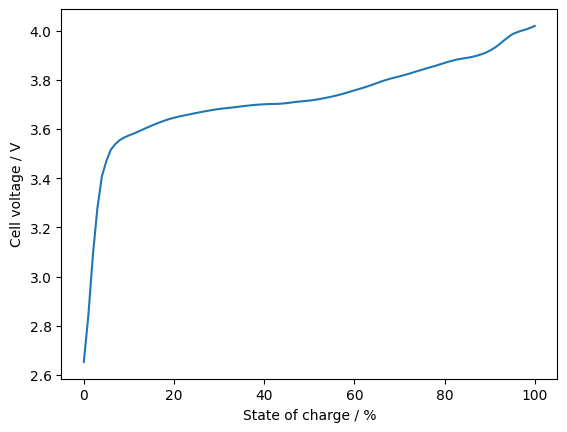

In [ ]:
"""
This example calculates the cell voltage of a lithium-ion battery at
given temperature, pressure, current, and range of state of charge (SOC).

The thermodynamics are based on a graphite anode and a LiCoO2 cathode,
modeled using the 'BinarySolutionTabulatedThermo' class.
Further required cell parameters are the electrolyte ionic resistance, the
stoichiometry ranges of the active materials (electrode balancing), and the
surface area of the active materials.

The functionality of this example is presented in greater detail in a jupyter
notebook as well as the reference (which also describes the derivation of the
'BinarySolutionTabulatedThermo' class):

Reference:
M. Mayur, S. C. DeCaluwe, B. L. Kee, W. G. Bessler, â€œModeling and simulation
of the thermodynamics of lithium-ion battery intercalation materials in the
open-source software Cantera,â€ Electrochim. Acta 323, 134797 (2019),
https://doi.org/10.1016/j.electacta.2019.134797

Requires: cantera >= 2.6.0, matplotlib >= 2.0
Keywords: surface chemistry, kinetics, electrochemistry, battery, plotting
"""

import cantera as ct
import numpy as np

# Parameters
samples = 101
soc = np.linspace(0., 1., samples)  # [-] Input state of charge (0...1)
current = -1  # [A] Externally-applied current, negative for discharge
T = 293  # [K] Temperature
P = ct.one_atm  # [Pa] Pressure

# Cell properties
input_file = "lithium_ion_battery.yaml"  # Cantera input file name
R_electrolyte = 0.0384  # [Ohm] Electrolyte resistance
area_cathode = 1.1167  # [m^2] Cathode total active material surface area
area_anode = 0.7824  # [m^2] Anode total active material surface area

# Electrode balancing: The "balancing" of the electrodes relates the chemical
# composition (lithium mole fraction in the active materials) to the macroscopic
# cell-level state of charge.
X_Li_anode_0 = 0.01  # [-] anode Li mole fraction at SOC = 0
X_Li_anode_1 = 0.75  # [-] anode Li mole fraction at SOC = 100
X_Li_cathode_0 = 0.99  # [-] cathode Li mole fraction at SOC = 0
X_Li_cathode_1 = 0.49  # [-] cathode Li mole fraction at SOC = 100

# Calculate mole fractions from SOC
X_Li_anode = (X_Li_anode_1 - X_Li_anode_0) * soc + X_Li_anode_0
X_Li_cathode = (X_Li_cathode_0 - X_Li_cathode_1) * (1 - soc) + X_Li_cathode_1

# Import all Cantera phases
anode = ct.Solution(input_file, "anode")
cathode = ct.Solution(input_file, "cathode")
metal = ct.Solution(input_file, "electron")
electrolyte = ct.Solution(input_file, "electrolyte")
anode_int = ct.Interface(
    input_file, "edge_anode_electrolyte", adjacent=[anode, metal, electrolyte])
cathode_int = ct.Interface(
    input_file, "edge_cathode_electrolyte", adjacent=[cathode, metal, electrolyte])

# Set the temperatures and pressures of all phases
for phase in [anode, cathode, metal, electrolyte, anode_int, cathode_int]:
    phase.TP = T, P


# Root finding function
def newton_solve(f, xstart, C=0.0):
    """
    Solve f(x) = C by Newton iteration using initial guess *xstart*
    """
    f0 = f(xstart) - C
    x0 = xstart
    dx = 1.0e-6
    n = 0
    while n < 200:
        ff = f(x0 + dx) - C
        dfdx = (ff - f0) / dx
        step = - f0 / dfdx

        # avoid taking steps too large
        if abs(step) > 0.1:
            step = 0.1 * step / abs(step)

        x0 += step
        emax = 0.00001  # 0.01 mV tolerance
        if abs(f0) < emax and n > 8:
            return x0
        f0 = f(x0) - C
        n += 1
    raise Exception("no root!")


# This function returns the Cantera calculated anode current (in A)
def anode_current(phi_s, phi_l, X_Li_anode):
    """
    Current from the anode as a function of anode potential relative to
    electrolyte.
    """
    # Set the active material mole fraction
    anode.X = {"Li[anode]": X_Li_anode, "V[anode]": 1 - X_Li_anode}

    # Set the electrode and electrolyte potential
    metal.electric_potential = phi_s
    electrolyte.electric_potential = phi_l

    # Get the net reaction rate at the anode-side interface
    # Reaction according to input file:
    # Li+[electrolyte] + V[anode] + electron <=> Li[anode]
    r = anode_int.net_rates_of_progress  # [kmol/m2/s]

    # Calculate the current. Should be negative for cell discharge.
    return r * ct.faraday * area_anode


# This function returns the Cantera calculated cathode current (in A)
def cathode_current(phi_s, phi_l, X_Li_cathode):
    """
    Current to the cathode as a function of cathode potential relative to electrolyte
    """
    # Set the active material mole fractions
    cathode.X = {"Li[cathode]": X_Li_cathode, "V[cathode]": 1 - X_Li_cathode}

    # Set the electrode and electrolyte potential
    metal.electric_potential = phi_s
    electrolyte.electric_potential = phi_l

    # Get the net reaction rate at the cathode-side interface
    # Reaction according to input file:
    # Li+[electrolyte] + V[cathode] + electron <=> Li[cathode]
    r = cathode_int.net_rates_of_progress  # [kmol/m2/s]

    # Calculate the current. Should be negative for cell discharge.
    return - r * ct.faraday * area_cathode


# Calculate cell voltage, separately for each entry of the input vectors
V_cell = np.zeros_like(soc)
phi_l_anode = 0
phi_s_cathode = 0
for i in range(samples):
    # Set anode electrode potential to 0
    phi_s_anode = 0

    # Calculate anode electrolyte potential
    phi_l_anode = newton_solve(
        lambda E: anode_current(phi_s_anode, E, X_Li_anode[i]),
        phi_l_anode, C=current)

    # Calculate cathode electrolyte potential
    phi_l_cathode = phi_l_anode + current * R_electrolyte

    # Calculate cathode electrode potential
    phi_s_cathode = newton_solve(
        lambda E: cathode_current(E, phi_l_cathode, X_Li_cathode[i]),
        phi_s_cathode, C=current)

    # Calculate cell voltage
    V_cell[i] = phi_s_cathode - phi_s_anode

try:
    import matplotlib.pyplot as plt

    # Plot the cell voltage, as a function of the state of charge
    plt.plot(soc * 100, V_cell)
    plt.xlabel("State of charge / %")
    plt.ylabel("Cell voltage / V")
    plt.show()

except ImportError:
    print("Install matplotlib to plot the outputs")